In [33]:
# If memory/processing speed becomes an issue, may need to launch Jupyter from terminal with 
# "jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000"

# Necessary imports:

import imageio
import itertools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from scipy import ndimage, misc, stats
from scipy.misc import imsave
from scipy.ndimage.filters import minimum_filter
from matplotlib.font_manager import FontProperties
from sklearn.mixture import GMM
from sklearn.cluster import KMeans

# http://zulko.github.io/moviepy/
from moviepy.editor import *
import pygame
%matplotlib inline
imageio.plugins.ffmpeg.download()

In [2]:
### Style ###

# set graph size:
size = (6, 3.5)

# set distance between header and top of graph
header_space = 0.88 

In [3]:
# RGB to grayscale function:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [4]:
# Create a list of video files to score.
# VIDEOS MUST FIRST BE STORED IN YOUR JUPYTER ENVIRONMENT!

video_files = [VideoFileClip("motion_test.mov"), VideoFileClip("test_vid_2.mov"), VideoFileClip("test_vid_4.mov"), VideoFileClip("test_vid_5.mov")]

314
1251
870
698


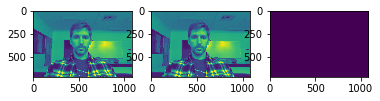

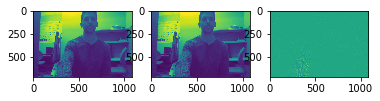

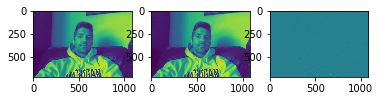

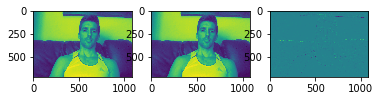

In [5]:
sum_sq_diff_list = []

r_squared_values_list = []

# Loop over each video to be scored:
for video in video_files:
    sum_sq_diff = []
    r_squared_values = []
    #pearson = []
    prev_frame = []
    total_frames = 0
    
    # Within each video, loop over individual frames, comparing each frame to its preceding frame:
    for frame in video.iter_frames(fps=30):
        this_frame = rgb2gray(frame)
        if prev_frame != []:
            total_frames += 1
            
            # Get the delta between contiguous frames:
            diff_frame = this_frame-prev_frame
            r_squared = (np.corrcoef(np.ravel(this_frame), np.ravel(prev_frame))[0,1])**2
            r_squared_values.append(r_squared)
            
            # Square each delta to eliminate negative values:
            diff_frame_sq = np.power(diff_frame, 2)
            sum_diff_frame_sq = np.sum( diff_frame_sq )
            sum_sq_diff.append( sum_diff_frame_sq )
            
            # Get the r-squared (or Pearson's) correlation coefficient between each frame:
            # ::: Do something to diff_frame to get this value; store that value a float variable :::
            # ::: Append the value to the "pearson = []" list :::
            
        prev_frame = this_frame
        
    # Append the full list of squared deltas to a master list of 
    # squared deltas for each of the n videos to be scored:
    sum_sq_diff_list.append(sum_sq_diff)
    r_squared_values_list.append(r_squared_values)
    print total_frames
    
    # Plot some contiguous frames and delta frames from each video:
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(this_frame)
    axarr[1].imshow(prev_frame)
    axarr[2].imshow(diff_frame)

Outlying value -31.4384832031 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -30.7453360226 has been replaced with 0 in Video 4's log-transformed normalized data.


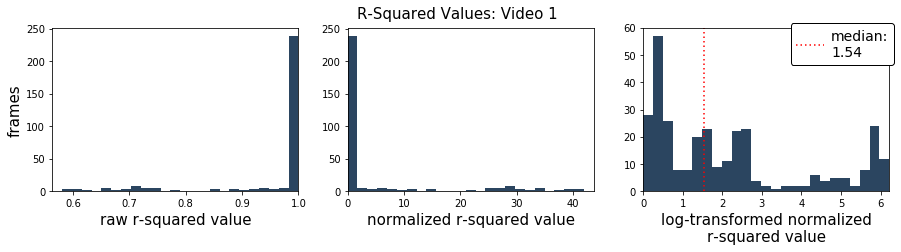

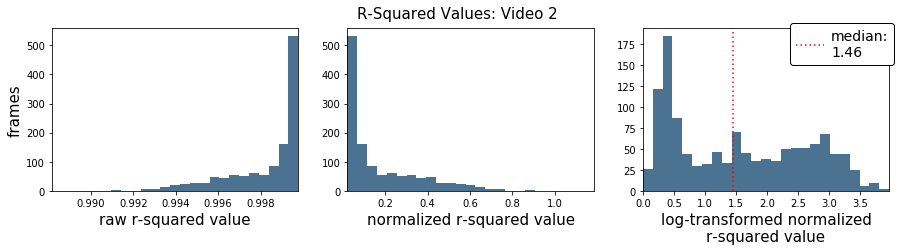

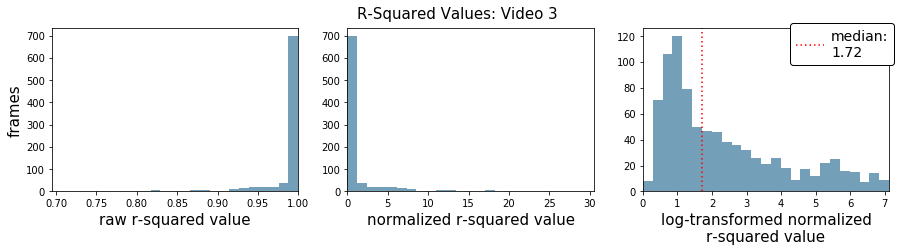

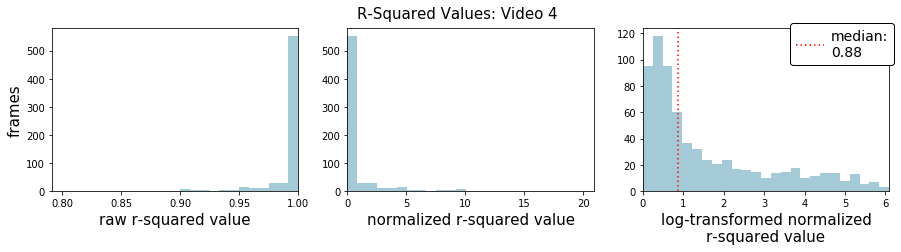

In [65]:
###PLOT AND STORE RAW, NORMALIZED, AND LOG-TRANSFORMED/NORMALIZED R-SQUARED VALUES ###

palette = sns.cubehelix_palette(n_colors = len(r_squared_values_list), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

count = 0

normalized_r2_values = []
log_transformed_normalized_r2_values = []
outliers_list = []

# Iterate over the list of lists of r-squared values:
for values in r_squared_values_list:
    
    temp_normalized_values = []
    temp_log_transformed_normalized_values = []
    
    # Iterate over each r-squared value, to get/store normalized and log-transformed/normalized values:
    for value in values:
        
        # Get normalized values:
        norm_value = (1 - value) * 100
        temp_normalized_values.append(norm_value)
        
        # Get log-transformed normalized values:
        log_transformed = np.log(norm_value) # Constant added to avoid negative values
        if np.isfinite(log_transformed) == True:
            temp_log_transformed_normalized_values.append(log_transformed)
        else:
            temp_log_transformed_normalized_values.append(0)
    
    # We are getting a few extreme outliers in the temp_log_transformed_normalized_values list.
    # These outliers are skewing our graphs, so we have done some manipulations to eliminate them 
    # using relative absolute distance from the median. This way, the filter will work for any inputs:
    
    log_median = np.median(temp_log_transformed_normalized_values)
        
    # Iterate over each value in temp_log_transformed_normalized_values and calculate/store the absolute
    # distance from the median for each:
    log_abs_dists = []
    for log in temp_log_transformed_normalized_values:
        dist = abs(log - log_median)
        log_abs_dists.append(dist)
        
    log_median_abs_dist = np.median(log_abs_dists)
            
    # Iterate over each value in temp_log_transformed_normalized_values and check to see whether it's an outlier.
    # If it is an outlier, change the value to zero. If not, pass.
    outliers = []
    count_2 = 0    
    for i in temp_log_transformed_normalized_values:
        sensitivity = 3 # A smaller value will capture more outliers; large values assume large "spread"
        if abs(i) > abs(log_median) + (sensitivity * log_median_abs_dist):
            outliers.append(i)
            print "Outlying value {} has been replaced with 0 in Video {}'s log-transformed normalized data.".format(i, count + 1)
            temp_log_transformed_normalized_values[count_2] = 0
        else:
            pass
        count_2 += 1

    outliers_list.append(outliers)
    
    # Plot histograms of the normalized r-squared values:
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), sharex=False, sharey=False, subplot_kw={'adjustable': 'box-forced'})
    fig.suptitle('R-Squared Values: Video {}'.format(count + 1), fontsize=15)
    ax = axes.ravel()

    # Unadjusted r-squared scores:
    ax[0].set_ylabel('frames', fontsize = 15)
    ax[0].set_xlabel('raw r-squared value', fontsize = 15)
    ax[0].hist(values, bins=25, color = palette[count]);
    ax[0].set_ylim(bottom=0)
    ax[0].set_xlim(left=min(values), right=max(values))

    # Normalized r-squared scores:
    ax[1].set_xlabel('normalized r-squared value', fontsize = 15)
    ax[1].hist(temp_normalized_values, bins=25, color = palette[count]);
    ax[1].set_ylim(bottom=0)
    ax[1].set_xlim(left=min(temp_normalized_values), right=max(temp_normalized_values))
    
    # Log-transformed r-squared scores:
    plot_me = temp_log_transformed_normalized_values - min(temp_log_transformed_normalized_values)
    #print np.median
    ax[2].set_xlabel('log-transformed normalized\nr-squared value', fontsize = 15)
    ax[2].hist(plot_me, bins=25, color = palette[count]);
    ax[2].set_ylim(bottom=0)
    ax[2].set_xlim(left=0, right=max(plot_me))
    ax[2].axvline(x = np.median(plot_me), c = "r", dashes = [1, 2], label = "median:\n{:.2f}".format(np.median(plot_me)))
    ax[2].legend(bbox_to_anchor=(1.02, 1.03), loc="upper right", borderaxespad=0., fontsize = 14, frameon=True, framealpha=1, edgecolor = "inherit", handletextpad=.5)
    
    # Store each list of normalized r-squared values outside the loop for later use:
    normalized_r2_values.append(temp_normalized_values)
    log_transformed_normalized_r2_values.append(temp_log_transformed_normalized_values)
        
    count += 1

In [ ]:
# Several lists generated in the following for loop will need to be saved as lists of sub-lists for later use:
sum_sq_diff_nparray_list = []
min_vectors_list = []
max_vectors_list = []
my_ordered_array_list = []

count = 0

for sum_of_sq_differences in sum_sq_diff_list:
    min_vectors = []    
    n = 10 # This can be changed to alter sensitivity of the filter. A lower value would be LESS sensitive to motion.
    sum_sq_diff_nparray = np.array(sum_of_sq_differences)
    sum_sq_diff_nparray = ((sum_sq_diff_nparray)/max(sum_sq_diff_nparray))*100

    # Use a sliding window of n-frames to calculate the highest and lowest
    # deltas among those frames. Store those values as max and min vectors.
    # Large divergence in max/min values indicates motion.
    min_vector = minimum_filter(sum_sq_diff_nparray, size=n, mode='constant')
    max_vector = minimum_filter(sum_sq_diff_nparray*-1, size=n, mode='constant')*-1

    print np.mean(min_vector)
    my_ordered_array = np.arange(0,len(sum_of_sq_differences))

    # Generate plots:
    fig = plt.figure()
    fig.set_size_inches(size)
    fig.suptitle('Frame-by-Frame Filter Scores: Video {}'.format(count + 1), fontsize = 15)

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=header_space)

    ax.set_xlabel('frame', fontsize = 15)
    ax.set_ylabel('filter scores', fontsize = 15)

    plt.plot(my_ordered_array, min_vector, 'b-', label = "minimum filter", alpha = .5, linewidth = 2)
    plt.plot(my_ordered_array, max_vector, 'g-', label = "maximum filter", alpha = .5, linewidth = 2)
    plt.plot(my_ordered_array, normalized_r2_values[count], 'r-', label = "r-squared values", alpha = .5, linewidth = 2)

    ax.legend(bbox_to_anchor=(1.25, 0.5), loc="center", borderaxespad=0., fontsize = 14, frameon=False, handletextpad=.5)
    
    # Store necessary data in their respective lists for later use:
    sum_sq_diff_nparray_list.append(sum_sq_diff_nparray)
    min_vectors_list.append(min_vector)
    my_ordered_array_list.append(my_ordered_array)
    max_vectors_list.append(max_vector)
    
    count += 1

In [ ]:
freezing_list = []

#freezing_threshold_list = [] # We can reactivate this line if we set a dynamic freezing threshold

count = 0

for min_vector in min_vectors_list:
    # Create a min_vector-length array of zeros:
    freezing = np.zeros_like(min_vector)
    
    # Filter-out noise. 
    # Lower values would be more sensitive to motion.
    # Give it a try by changing the threshold to a 
    # different value and re-examining the plots.
    freezing_threshold = 4
    freezing[min_vector < freezing_threshold] = max(min_vector)

    # Generate plots:
    fig = plt.figure()
    fig.set_size_inches(size)
    fig.suptitle('Filtered Motion Score: Video {}'.format(count +1), fontsize=15)

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=header_space)

    ax.set_xlabel('frame', fontsize = 15)
    ax.set_ylabel('filter scores', fontsize = 15)

    plt.plot(my_ordered_array_list[count], min_vector, 'b-', label = "minimum vector")
    plt.plot(my_ordered_array_list[count], freezing, "g-", label = '"freezing" score')
    plt.axhline(y = np.mean(min_vectors_list[count]), c = "r", dashes = [1, 2], label = "mean minimum vector: {:.2f}".format(np.mean(min_vectors_list[count])))

    ax.legend(bbox_to_anchor=(1.38, 0.5), loc="center", borderaxespad=0., fontsize = 14, frameon=False, handletextpad=.5)
    
    # Store freezing values for each of the n videos as a list of sub-lists, for later use:
    freezing_list.append(freezing)
    
    #freezing_threshold_list.append(freezing_threshold) # We can reactivate this line if we set a dynamic freezing threshold
    
    count += 1

In [ ]:
# Plot the maximum vector scores from each video as a histogram to visualize
# the ostensibly bimodal distribution of scores that indicate freezing/motion: 

palette = sns.cubehelix_palette(n_colors = len(max_vectors_list), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

count = 0

for max_vector in max_vectors_list:
    fig = plt.figure()
    fig.suptitle('Distribution of Maximum Filter Scores: Video{}'.format(count + 1), fontsize=15)

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=header_space)
    fig.set_size_inches(size)

    ax.set_xlabel('maximum filter score', fontsize = 15)
    ax.set_ylabel('frames', fontsize = 15)

    plt.hist(max_vector, bins=50, color = palette[count]);
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=0)
    
    count += 1

In [ ]:
### LOG TRANSFORMED PLOTS ###
# Transforming the data to their natural logs will facilitate better visualization and analysis.

max_vector_logs = []

palette = sns.cubehelix_palette(n_colors = len(max_vectors_list), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

count = 0

for max_vector in max_vectors_list:
    # Log-transform the data with an added constant to avoid negative values:
    max_vector_log = np.log(max_vector + 1 - min(max_vector))
    max_vector_logs.append(max_vector_log)

    # Generate log-transformed plots:
    fig = plt.figure()
    fig.suptitle('Distribution of Log-Transformed Maximum Filter Scores: Video {}'.format(count + 1), fontsize=15)
    fig.set_size_inches(size)

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=header_space)

    ax.set_xlabel('log-transformed maximum filter score', fontsize = 15)
    ax.set_ylabel('frames', fontsize = 15)

    plt.hist(max_vector_log, color = palette[count])
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=0, right=max(max_vector_log))
    
    count += 1

In [ ]:
# ::: I should probably run this 10-20 (or more?) times and select the modal BIC value for plotting
# ::: and future use, to hedge against the prospect of an improbable BIC score winning out.

### MODEL COMPARISONS ###

count = 1

min_aics = []
min_bics = []

# Iterate over the lists of log-transformed max vector scores:
for max_vector_log in max_vector_logs:
        
    # Reshape the data to facilitate Gaussian modeling:
    max_vector_log.shape = (max_vector_log.shape[0],1)
    
    # Test models for each video against a range of GMMs with between 1 and 10 underlying Gaussians:
    n_estimators = np.arange(1, 15)
    clfs = [GMM(n, n_iter=1000).fit(max_vector_log) for n in n_estimators]
    aics = [clf.aic(max_vector_log) for clf in clfs]
    bics = [clf.bic(max_vector_log) for clf in clfs]
    
    #Grab the lowest AIC and BIC scores from each video's model trials.
    # The lowest scores correspond to the optimal number of Gaussians to use
    # per video, so we can grab each of those by indexing the aics/bics lists
    # for lowest values (and then adding 1 to account for zero-indexing):
    min_aics.append(aics.index(min(aics))+1)
    min_bics.append(bics.index(min(bics))+1)

    # Plot the AIC and BIC scores:
    fig = plt.figure() 
    ax = fig.add_subplot(111)  
    
    fig.suptitle("Comparing 1-Dimensional n-Gaussian Models\n via AIC and BIC Testing: Video {}".format(count), fontsize=16)

    fig.subplots_adjust(top=header_space - .05)

    plt.plot(n_estimators, aics, label= "Lowest AIC = {:.2f} at {} Gaussians".format(min(aics), aics.index(min(aics))+1))
    plt.plot(n_estimators, bics, label= "Lowest BIC = {:.2f} at {} Gaussians".format(min(bics), bics.index(min(bics))+1))
    plt.legend(fontsize = 14, bbox_to_anchor=(1.49, 0.5), loc="center", frameon = False)
    plt.axvline(x = aics.index(min(aics))+1, color = "blue", ls = "dotted")
    plt.axvline(x = bics.index(min(bics))+1, color = "orange", ls = "dotted")

    ax = plt.gca()

    ax.set_xlabel("Number of Gaussians", fontsize = 15)
    ax.set_ylabel("AIC/BIC Score", fontsize = 15)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

    count += 1
    
print min_aics
print min_bics

In [ ]:
### PLOT GAUSSIAN MIXTURE MODEL W/ LOWEST BIC SCORE PER VIDEO ###
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.mixture.GMM.html

def Gaussian_mixture_model(posterior_probability_check = None):

    optimal_peaks = []
    
    for item in range(len(max_vector_logs)):
        optimal_peaks.append(min_bics[item])
    
    palette = sns.cubehelix_palette(n_colors = len(max_vector_logs), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

    count = 0

    # Save some values to use later:
    xpdf_list = []
    density_list = []
    clf_list = []

    # Iterate over max_vector_logs to generate histograms and composite Gaussians
    for max_vector_log in max_vector_logs:

        # Reshape the data to facilitate Gaussian modeling:
        max_vector_log.shape = (max_vector_log.shape[0],1)

        # Set the Gaussian mixed model to fit 2 Gaussians;
        # conduct 300 iterations to determine the best fit:
        clf = GMM(optimal_peaks[count], n_iter = 300).fit(max_vector_log)
        clf_list.append(clf)

        # Reshape the data to facilitate probability density polotting:
        xpdf = np.linspace(-2, 7, 1000)
        xpdf.shape = (xpdf.shape[0], 1)
        xpdf_list.append(xpdf)

        density = np.exp(clf.score(xpdf))
        density_list.append(density)

        # Generate plots:
        fig = plt.figure()

        plt.hist(max_vector_log, 10, normed = True, color = palette[count], alpha = 1)
        plt.plot(xpdf, density, "r-")
        plt.xlim(-2, 7)
        fig.set_size_inches(size)

        fig.suptitle("1-Dimensional Gaussian Mixture Model:\nFreezing and Motion Frames: Video {}".format(count + 1), fontsize=16)

        fig.subplots_adjust(top=header_space - .05)

        ax = plt.gca()

        ax.set_xlabel("Log-Transformed Maximum Filter Score", fontsize = 15)
        ax.set_ylabel("Probability Density", fontsize = 15)

        ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

        patch = mpatches.Patch(facecolor="#D8D8D8", edgecolor = "red", linewidth = "1.5", label="Winning model:\n{} Underlying Gaussians\nBIC: {:.2f}".format(optimal_peaks[count], clf.bic(max_vector_log)))
        plt.legend(handles=[patch], fontsize = 14, bbox_to_anchor=(1.35, 0.5), loc="center", frameon = False)

        count += 1
        
        # Check the posterior probability of any number falling within each model's n Gaussians:
        
        posteriors = []
        
        def posterior_prob_check(num):
            # Check to see whether the user has entered the optional argument posterior_probability_check
            if posterior_probability_check != None:
                # Iterate over each clf.predict_proba np.array:
                for i in clf.predict_proba(num):
                    # Pull each value out of its respective array and append it to posteriors = []
                    for k in i:
                        posteriors.append(k)
            else:
                pass
            
        posterior_prob_check(posterior_probability_check)
                
        # Iterate over each underlying Gaussian distribution, plotting and printing summary statistics for each:
        print "Video {}:\n".format(count)
        for i in range(clf.n_components):
            pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0], np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
            print "Gaussian {}:".format(i+1), "AUC: {:.3f};".format(clf.weights_[i]), "Mean: %.4f;" % round(clf.means_[i], 4), "Covariance: %.3f;" % round(clf.covars_[i], 3), "Posterior probability of {}:".format(posterior_probability_check), "%.4f" % round(posteriors[i], 3)
            plt.fill(xpdf, pdf, facecolor = "grey", edgecolor= None, alpha=0.5)
            plt.xlim(-2, 7);
        print ""
        plt.show()
        print ""
    
Gaussian_mixture_model(0.5)

In [ ]:
### PLOT GAUSSIAN MIXTURE MODEL W/ LOWEST BIC SCORE PER VIDEO ###
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.mixture.GMM.html

def Gaussian_mixture_model(posterior_probability_check = None):

    optimal_peaks = []
    
    for item in range(len(max_vector_logs)):
        optimal_peaks.append(min_bics[item])
    
    palette = sns.cubehelix_palette(n_colors = len(max_vector_logs), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

    count = 0

    # Save some values to use later:
    xpdf_list = []
    density_list = []
    clf_list = []

    # Iterate over max_vector_logs to generate histograms and composite Gaussians
    for max_vector_log in max_vector_logs:

        # Reshape the data to facilitate Gaussian modeling:
        max_vector_log.shape = (max_vector_log.shape[0],1)

        # Set the Gaussian mixed model to fit 2 Gaussians;
        # conduct 300 iterations to determine the best fit:
        clf = GMM(optimal_peaks[count], n_iter = 300).fit(max_vector_log)
        clf_list.append(clf)

        # Reshape the data to facilitate probability density polotting:
        xpdf = np.linspace(-2, 7, 1000)
        xpdf.shape = (xpdf.shape[0], 1)
        xpdf_list.append(xpdf)

        density = np.exp(clf.score(xpdf))
        density_list.append(density)

        # Generate plots:
        fig = plt.figure()

        plt.hist(max_vector_log, 10, normed = True, color = palette[count], alpha = 1)
        plt.plot(xpdf, density, "r-")
        plt.xlim(-2, 7)
        fig.set_size_inches(size)

        fig.suptitle("1-Dimensional Gaussian Mixture Model:\nFreezing and Motion Frames: Video {}".format(count + 1), fontsize=16)

        fig.subplots_adjust(top=header_space - .05)

        ax = plt.gca()

        ax.set_xlabel("Log-Transformed Maximum Filter Score", fontsize = 15)
        ax.set_ylabel("Probability Density", fontsize = 15)

        ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

        patch = mpatches.Patch(facecolor="#D8D8D8", edgecolor = "red", linewidth = "1.5", label="Winning model:\n{} Underlying Gaussians\nBIC: {:.2f}".format(optimal_peaks[count], clf.bic(max_vector_log)))
        plt.legend(handles=[patch], fontsize = 14, bbox_to_anchor=(1.35, 0.5), loc="center", frameon = False)

        count += 1
        
        # Check the posterior probability of any number falling within each model's n Gaussians:
        
        posteriors = []
        
        def posterior_prob_check(num):
            # Check to see whether the user has entered the optional argument posterior_probability_check
            if posterior_probability_check != None:
                # Iterate over each clf.predict_proba np.array:
                for i in clf.predict_proba(num):
                    # Pull each value out of its respective array and append it to posteriors = []
                    for k in i:
                        posteriors.append(k)
            else:
                pass
            
        posterior_prob_check(posterior_probability_check)
                
        # Iterate over each underlying Gaussian distribution, plotting and printing summary statistics for each:
        print "Video {}:\n".format(count)
        for i in range(clf.n_components):
            pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0], np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
            print "Gaussian {}:".format(i+1), "AUC: {:.3f};".format(clf.weights_[i]), "Mean: %.4f;" % round(clf.means_[i], 4), "Covariance: %.3f;" % round(clf.covars_[i], 3), "Posterior probability of {}:".format(posterior_probability_check), "%.4f" % round(posteriors[i], 3)
            plt.fill(xpdf, pdf, facecolor = "grey", edgecolor= None, alpha=0.5)
            plt.xlim(-2, 7);
        print ""
        plt.show()
        print ""
    
Gaussian_mixture_model(0.5)

### K-MEANS CLUSTERING FOR 2-DIMENSIONAL DATA


In [ ]:
# Trying to prep the r_squared_values_list and max_vector_logs data for k-means clustering

q = np.asarray(r_squared_values_list[1])
z = max_vector_logs[1]


qz = np.concatenate([q, max_vector_logs])
print qz[:1]

print q[1], z[1]
print type(r_squared_values_list[1])
print type(max_vector_logs[1])

In [ ]:
x = np.array([[1, 2], [3, 2], [5, 8], [7, 3], [8, 6], [2, 1], [1, 1], [6, 6], [5, 4], [2, 2], [7, 7]])
plt.scatter(x[:, 0], x[:, 1], s = 40)
plt.show()

In [ ]:
def kmeans_cluster(input_data, clusters):
    reshaped_input = input_data
    #reshaped_input.shape = (reshaped_input.shape[0],1)
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(reshaped_input)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    colors = 10*["orange", "blue", "green", "red"]
    markers = ["x", "^"]
    
    count = 0
    
    for i in range(len(reshaped_input)):
        #print("coordinate:", reshaped_input[i])
        plt.plot(reshaped_input[i][0], reshaped_input[i][1], colors[labels[i]], marker = ".", markersize = 10)
        sns.despine()
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = ".", color = "black", s = 150, linewidths = 20, alpha = 0.15)

In [ ]:
kmeans_cluster(x, 2)

In [ ]:
clf = KMeans(n_clusters = 2)
clf.fit(x)
centroids = clf.cluster_centers_
labels = clf.labels_

#palette = sns.cubehelix_palette(n_colors = len(labels), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

#count = 0

for i in range(len(x)):
    plt.plot(x[i][0], x[i][1], markersize = 10)
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = "red", s = 150, linewidths = 5)
plt.show()
    #count += 1

### Map natural log values to their respective time points


In [ ]:
# Map natural log values to their respective time points:

count = 0

for log in max_vector_logs:
    # Iterate over freezing_list to obtain and temp. store nlog values for plot overlays
    freezing_logs = []
    for freezing in freezing_list:
        freezing_log = np.log(freezing + 1 - min(freezing))
        freezing_logs.append(freezing_log)

    fig = plt.figure()
    fig.suptitle("Log-Transformed Scores (Video {})".format(count + 1), fontsize = 15)
    fig.set_size_inches(size)

    fig.subplots_adjust(top=header_space)
    
    ax = plt.gca()
    ax.set_xlabel("frame", fontsize = 15)
    ax.set_ylabel("natural log value", fontsize = 15)

    plt.plot(my_ordered_array_list[count], log, label = "motion score")
    plt.plot(my_ordered_array_list[count], freezing_logs[count], "g-", label = '"freezing" score (filtered)')

    ax.legend(bbox_to_anchor=(1.34, 0.5), loc="center", borderaxespad=0., fontsize = 14, frameon=False, handletextpad=.5)
    
    count += 1

## Back Converting Natural Logs to their Antilogs:

In [ ]:
### THERE IS NO NEED TO RUN THIS CODE. THIS IS JUST VERIFICATION THAT OUR NLOG CONVERSIONS ARE REVERSIBLE. ###

# # Map data BACK to video by un-logging.
# # Need to ensure that the un-logging goes back far enough to get timestamped data, so that
# # the data can be mapped to the video to see whether the mean of each distribution is a viable
# # binary threshold for categorizing the animal as moving/not moving

# logs_to_back_convert = max_vector_logs

# # 		If you were given ln(x) = 1.3 then x = inverse natural log of 1.3 or the natural
# # 		antilog of 1.3 or 
# # 		x = e1.3=3.669

# # The exponential function is e^x where e is a mathematical constant 
# # called Euler's number, approximately 2.718281.

# print min(max_vector)
# print max(max_vector)
# print max_vector[1]
# test_log = np.log(max_vector[1] + 1 - min(max_vector))
# print test_log
# antilog = np.exp(test_log) - (1 - min(max_vector))
# print antilog

# unlogged_list = []

# def unlogged(natural_logs):
#     for log in natural_logs:
#         unlogged_list.append(np.exp(log) - (1 - min(max_vector)))
#     return(0)

# unlogged(logs_to_back_convert)

# # So, back-conversion works fine, and we can preserve order,
# # but I need to think a bit more about what this has bought us.

In [ ]:
# freezing_logs = []

# for freezing in freezing_list:
#     freezing_log = np.log(freezing + 1 - min(freezing))
#     freezing_logs.append(freezing_log)
    
# len(freezing_logs)
# print len(freezing_logs[1])

# print freezing_logs[1]
# print max_vector_logs[1]

## Video exporting begins here.
## Currently a lower priority. 
## Eventually, need to work out a way to do this task iteratively.

In [ ]:
video_to_export = VideoFileClip("motion_test.mov")

In [ ]:
test_mask = freezing
test_mask = np.insert(test_mask, 0, 0.0) 
print test_mask[4]
def test_func(t):
    return test_mask[int(round(t*30))]*100 #How did we arrive at this?

In [ ]:
print test_mask.shape

In [ ]:
from moviepy.editor import *
from moviepy.video.tools.drawing import circle

clip = VideoFileClip("motion_test.mov", audio=False).add_mask()
clip2 = VideoFileClip("motion_test.mov", audio=False).add_mask()

w,h = clip.size

# This mask creates a persistent black circle.
clip.mask.get_frame = lambda t: circle(screensize=(clip.w,clip.h),
                                       center=(clip.w/10,clip.h/5),
                                       radius=50,col1=0, col2=1, blur=4)

# The mask is a circle with vanishing radius r(t) = 800-200*t that 
# conditionally "erases" the persistent circle when motion is detected.
clip2.mask.get_frame = lambda t: circle(screensize=(clip.w,clip.h),
                                       center=(clip.w/10,clip.h/5),
                                       radius=test_func(t),
                                       col1=1, col2=0, blur=4)

final = CompositeVideoClip([clip, clip2], size = clip.size)

final.write_videofile("motion_test_outcomeII.mp4")

In [ ]:
a = 5
b = 10
print "1: ", "a + b" # Python treats this as a literal string of characters, not as variables or math.
print "2: ", a + b # Python treats this as a math operation performed on two variables, which store integers.
print "3: ", a, "a + b" # Here, we're concatenating a variable (which stores an integer) and a character string.
print "4: ", str(a + b) # Here, we're doing a math operation on two variables, then storing the output as a string.